# Merge the NHTS with the EPA Fuel Economy Database and Sales Database
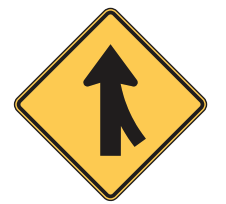

We have information on vehicle fuel economy and a large database of used vehicle listing. Merge the NHTS with these datasets to estimate fuel economy and value.

From https://www.fueleconomy.gov/feg/download.shtml

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import requests
from io import StringIO
from textlog import textSetup
text = textSetup(prefix='FuelEcon: ')
from collections import namedtuple
#text('Initializing notifications via text')
from time import sleep
import os.path

In [2]:
# read data
# make year model so that we can fuzzy match on model below
fueleconomy = pd.read_csv('../data/fuel_economy.csv', low_memory=False)
fueleconomy['model'] = fueleconomy.model.apply(lambda x: x.lower().strip())
fueleconomy = fueleconomy.set_index(['make', 'year', 'model'], drop=False).sortlevel()
vehicles = pd.read_csv('../data/nhts/vehpub.csv')


/Users/matthewc/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)


In [3]:
fueleconomy['hybrid'] = fueleconomy.eng_dscr.apply(lambda t: 'HEV' in str(t) and not 'GM-CHEV' in str(t))

In [4]:
# Some CSV lines had trailing commas in the original data. Remove using:
#   sed s/,$// data/tc20171021.csv > data/tc20171021_cleaned.csv 
sales = pd.read_csv('../data/tc20171021_cleaned.csv', usecols=range(1,9))

In [5]:
# Add spaces between components of model name
parseModelName = re.compile('([^A-Z-])([A-Z])')
sales['model'] = sales.Model.apply(lambda x: parseModelName.sub(r'\1 \2', x).lower())
sales['make'] = sales.Make.replace({ # align with NHTS
    'FIAT': 'Fiat',
    'HUMMER': 'Hummer',
    'INFINITI': 'Infiniti',
    'Land': 'Land Rover'
})
sales['year'] = sales.Year
sales = sales.set_index(['make', 'year', 'model'], drop=False)


In [6]:
# Many vehicles with multi word names have only the first word in this dataset
# this is generally only a minor annoyance, but Ford made two (very different) vehicles, the Explorer SUV and
# the Explorer Sport Trac pickup. Sort out the Explorers.  Subaru did the same with the Legacy and the Legacy Outback.
# only first 9 digits needed to identify type of vehicle, remainder are serial number
sales['vinStem'] = sales.Vin.apply(lambda x: x[:9])
vins = dict()
explorerVins = sales.loc[('Ford', [2001, 2002, 2003, 2004, 2005, 2007, 2008, 2009, 2010]),]
explorerVins = explorerVins.loc[explorerVins.model.apply(lambda m: m.startswith('explorer')),['vinStem','year']].drop_duplicates()
vins['explorer'] = explorerVins

subaruVins = sales.loc['Subaru', ['vinStem', 'year']].drop_duplicates()
vins['subaru'] = subaruVins

vins['grand'] = sales.loc[sales.model == 'grand', ['vinStem', 'year']].drop_duplicates()
# Yukon and Yukon XL are different (Chevy Tahoe vs. Chevy Suburban)
vins['yukon'] = sales.loc[('GMC', range(1997,2018), 'yukon'), ['vinStem', 'year']].drop_duplicates()

In [7]:
# this takes a while, but, believe it or not, the NHTSA does not have a cap on their VIN lookup service
# (at least, not yet...)
CHUNK_SIZE = 250
try:
    vinResults = []
    for key, vinList in vins.items():
        vinFile = f'../data/vins_{key}.csv'
        if os.path.exists(vinFile):
            print(f'using already-retrieved vin file for {key}')
            vinResults.append(pd.read_csv(vinFile))
        else:
            keyResults = []
            print(f'retriving {key} vins from vPIC')
            text(f'retriving {key} vins from vPIC')

            for i in range(CHUNK_SIZE, len(vinList) + CHUNK_SIZE, CHUNK_SIZE):
                lo = i - CHUNK_SIZE
                hi = min(i, len(vinList))
                payload = {
                    'DATA': ' '.join([f'{t.vinStem},{t.year};' for t in vinList.iloc[lo:hi].itertuples()]),
                    'format': 'csv'
                }
                for r in range(10):
                    try:
                        with requests.post('https://vpic.nhtsa.dot.gov/api/vehicles/DecodeVINValuesBatch/', data=payload) as r:
                            keyResults.append(pd.read_csv(StringIO(r.text)))
                            break # retry ten times
                    except:
                        print('retrying')
                        sleep(10)
                    else:
                        sleep(1)

                if i % 10000 == 0:
                    text(f'{i}/{len(vinList)} vins received for {key} ({i / len(vinList) * 100:.2f}%)')
            keyResults = pd.concat(keyResults, ignore_index=True)
            vinResults.append(keyResults)
            keyResults.to_csv(vinFile) # save this in case the NHTSA doesn't want to let me keep hitting their server
    vinResults = pd.concat(vinResults, ignore_index=True)
    text(f'retrieved {len(vinResults)} vins successfully')
finally:
    text('vin block done')
    

using already-retrieved vin file for explorer
using already-retrieved vin file for subaru
using already-retrieved vin file for grand
using already-retrieved vin file for yukon


In [8]:
vinResults = vinResults.rename(columns={'modelyear': 'year', 'vin': 'vinStem'})
vinResults['nhtsaModel'] = vinResults.model.apply(lambda x: str(x).lower())
sales = sales.merge(vinResults[['vinStem', 'year', 'nhtsaModel']], on=('vinStem', 'year'), how='left')
newModelNames = ~pd.isnull(sales.nhtsaModel)
sales.loc[newModelNames, 'model'] = sales.loc[newModelNames, 'nhtsaModel']

/Users/matthewc/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:3: FutureWarning: 'year' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  app.launch_new_instance()


In [9]:
sales.nhtsaModel.unique()

array([nan, 'caravan/grand caravan', 'explorer', 'explorer sport trac',
       'yukon xl', 'yukon', 'explorer sport', 'grand cherokee',
       'grand marquis', 'grand prix', 'grand am', 'xv crosstrek',
       'impreza', 'brz', 'b9 tribeca', 'legacy', 'forester', 'crosstrek',
       'outback', 'wrx', 'baja', 'grand vitara/grand vitara xl-7',
       'grand vitara', 'nan'], dtype=object)

In [10]:
sales = sales.set_index(['make', 'year', 'model'], drop=False).sortlevel()

/Users/matthewc/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sortlevel is deprecated, use sort_index(level= ...)
  if __name__ == '__main__':


In [11]:
vehicles['modelName'] = vehicles.MODEL.replace({
'-8': np.nan,
'-88': np.nan,
'12003': 'Mustang/Mustang II',
'12004': 'Thunderbird (all sizes)',
'12006': 'LTD/Custom/Galaxy (all sizes)',
'12013': 'Escort/EXP/ZX2',
'12016': 'Crown Victoria',
'12017': 'Taurus/Taurus X',
'12021': 'Five Hundred',
'12022': 'Freestyle',
'12023': 'Fusion',
'12024': 'Edge',
'12025': 'Flex',
'12027': 'C-Max',
'12032': 'Fiesta',
'12035': 'Contour',
'12037': 'Focus',
'12398': 'Other (automobile) Deluxe, Ford Six, Mainline,',
'12399': 'Unknown (automobile)',
'12401': 'Bronco (thru 1977)/Bronco II/Explorer/Explorer Sport',
'12402': 'Escape',
'12421': 'Bronco-full-size (1978 on)',
'12422': 'Expedition',
'12423': 'Excursion',
'12441': 'Aerostar',
'12442': 'Windstar',
'12443': 'Freestar',
'12444': 'Transit Connect',
'12461': 'E-Series Van/Econoline',
'12462': 'Transit',
'12470': 'Van Derivative',
'12471': 'Ranger',
'12473': 'Explorer Sport Trac',
'12481': 'F-Series pickup',
'12499': 'Unknown (light truck)',
'12850': 'Motor Home',
'12880': 'Medium/Heavy Pickup (pickup-style only – over 10,000 lbs.)',
'13001': 'Continental (thru 1981)/ Town Car',
'13005': 'Continental (1982 on)',
'13012': 'LS',
'13013': 'Zephyr/MKZ',
'13014': 'MKX',
'13015': 'MKS',
'13402': 'MKC',
'13421': 'Navigator',
'14004': 'Cougar (1967-1997) /XR7 (1967-1997)',
'14006': 'Marquis/Monterey (car version) /Grand Marquis',
'14017': 'Sable',
'14020': 'Montego (2005 on)',
'14021': 'Milan',
'14401': 'Mountaineer',
'14402': 'Mariner',
'14443': 'Villager',
'18002': 'LeSabre/Centurion/Wildcat',
'18003': 'Electra/Electra 225/Park Avenue (1991 on)',
'18004': 'Roadmaster',
'18005': 'Riviera',
'18007': 'Century',
'18010': 'Regal (RWD only)',
'18019': 'Regal (2011 on)',
'18020': 'Regal (FWD)',
'18022': 'LaCrosse',
'18023': 'Lucerne',
'18024': 'Enclave (2008-2012)',
'18025': 'Verano',
'18401': 'Rendezvous',
'18404': 'Encore',
'18421': 'Enclave (2013 on)',
'19003': 'Deville/Fleetwood (except Limousine)',
'19005': 'Eldorado',
'19014': 'Seville',
'19018': 'CTS/CTC',
'19020': 'SRX',
'19021': 'STS',
'19022': 'DTS',
'19023': 'XTS',
'19024': 'ATS',
'19421': 'Escalade/ESV (2004 on)',
'19480': 'Escalade EXT (2002 -2006)',
'19481': 'Escalade EXT (2007)',
'20001': 'Chevelle/Malibu (thru 1983)',
'20002': 'Impala/Caprice (2014 on)',
'20004': 'Corvette',
'20007': 'El Camino',
'20008': 'Nova (thru 1979)',
'20009': 'Camaro',
'2001': 'Compass',
'20010': 'Monte Carlo (thru 1988)',
'20016': 'Cavalier',
'20020': 'Lumina',
'20022': 'Cobalt',
'20023': 'HHR',
'20024': 'Traverse (2009-2012)',
'20025': 'Cruze',
'20026': 'Volt',
'20027': 'Caprice PPV',
'20028': 'Sonic',
'20029': 'Spark',
'20032': 'Nova/Geo Prism/Prism',
'20034': 'Geo Metro/Metro',
'20036': 'Monte Carlo (1995 on)',
'20037': 'Malibu/Malibu Maxx',
'20039': 'Aveo/Aveo 5',
'20401': 'S-10 Blazer/TrailBlazer (2002 only)',
'20402': 'Geo Tracker/Tracker',
'20403': 'TrailBlazer (2003 on)',
'20404': 'Equinox',
'20405': 'Captiva',
'20406': 'Trax',
'20421': 'Fullsize Blazer/Tahoe',
'20422': 'Suburban (2004 on)',
'20423': 'Traverse (2013 on)',
'20431': 'Suburban (1950-2003)',
'20441': 'Astro Van',
'20443': 'Venture',
'20444': 'Uplander',
'20445': 'City Express',
'20461': 'G-series van',
'20470': 'Van derivative',
'20471': 'S-10/T-10 Pickup',
'20473': 'Colorado',
'20481': 'C, K, R, V-Series pickup/Silverado',
'20482': 'Avalanche',
'20498': 'Other (light truck)',
'20499': 'Unknown (light truck)',
'20850': 'Motor Home',
'20870': 'Medium/Heavy Van-Based Vehicle',
'20880': 'Medium/Heavy Pickup (pickup-style only – over 10,000 lbs)',
'20881': 'Medium/Heavy – CBE',
'21001': 'Cutlass (RWD-only)',
'21002': 'Delta 88/LSS',
'21020': 'Cutlass (FWD)',
'21021': 'Achieva/Alero',
'21023': 'Intrigue',
'21401': 'Bravada',
'21441': 'Silhouette',
'22002': 'Bonneville/Catalina/ Parisienne',
'22009': 'Firebird/Trans AM',
'22010': 'Grand Prix (RWD)',
'22016': 'Sunbird (1985-1994) /J-2000/Sunfire (1995 on)',
'22018': 'Grand AM',
'22020': 'Grand Prix (FWD)',
'22022': 'G6',
'22023': 'Solstice',
'22032': 'Vibe',
'22403': 'Torrent',
'22441': 'Trans Sport/ Montana/SV6',
'23008': 'Acadia (2007-2012)',
'23401': 'Jimmy/Typhoon/Envoy',
'23402': 'Terrain',
'23421': 'Full-size Jimmy/Yukon',
'23422': 'Suburban/Yukon XL (2004 on)',
'23423': 'Acadia (2013 on)',
'23431': 'Suburban/Yukon XL (1950-2003 only)',
'23441': 'Safari (Minivan)',
'23461': 'G-series van/Savana',
'23471': 'S15/T15/Sonoma',
'23472': 'Canyon',
'23481': 'C, K, R, V-series pickup/Sierra',
'23499': 'Unknown (light truck)',
'23880': 'Medium/Heavy Pickup (pickup-style only – over 10,000 lbs)',
'24001': 'SL',
'24002': 'SC',
'24005': 'LS',
'24007': 'Ion',
'24009': 'Aura',
'2401': 'CJ-2/CJ-3/CJ-4',
'24010': 'Outlook',
'2402': 'CJ-5/CJ-6/CJ-7/CJ-8',
'2403': 'YJ series/Wrangler',
'2404': 'Cherokee (1984 on)',
'2405': 'Liberty',
'2406': 'Commander',
'2407': 'Patriot',
'2408': 'Renegade',
'2421': 'Cherokee (thru 1983)',
'2422': 'Grand Cherokee (2014 on)',
'24401': 'Vue',
'29005': 'Tesla',
'30032': 'Beetle 1300/1500',
'30033': 'Super Beetle',
'30036': 'Rabbit',
'30040': 'Jetta/Jetta SportsWagen',
'30042': 'Golf/Cabriolet/Cabrio/GTI/GLI',
'30046': 'Passat (CC 2008-2011)',
'30047': 'New Beetle',
'30051': 'Eos',
'30052': 'CC (2012 on)',
'30402': 'Tiguan',
'30421': 'Touareg/Touareg 2',
'30441': 'Vanagon/Camper',
'30443': 'Routan',
'32042': 'A6',
'32043': 'A4',
'32045': 'TT/TTS',
'32048': 'A3',
'32049': 'A5',
'32401': 'Q7',
'32402': 'Q5',
'3402': 'H3',
'34034': '3-series',
'34035': '5-series',
'34036': '6-series',
'34037': '7-series',
'34039': 'Z3',
'34042': 'Z4',
'34043': '1-Series',
'34047': '4-Series',
'34401': 'X5',
'34402': 'X3',
'34403': 'X1',
'34705': '450-749cc',
'34706': '750cc and over',
'35034': 'Z-car, ZX',
'35039': '810/Maxima',
'35043': 'Sentra',
'35047': 'Altima',
'35048': '350Z/370Z',
'35049': 'Murano',
'35050': 'Versa',
'35051': 'Rogue',
'35052': 'Cube',
'35055': 'Leaf',
'35401': 'Pathfinder',
'35402': 'Xterra',
'35403': 'Juke',
'35421': 'Pathfinder Armada',
'35443': 'Quest',
'35471': 'Datsun/Nissan Pickup (1955-1997)',
'35472': 'Frontier (1998 on)',
'35473': 'Titan (2004-2006)',
'35481': 'Titan (2007 on)',
'35499': 'Unknown (light truck)',
'36038': '500/500c',
'37031': 'Civic/CRX, del Sol',
'37032': 'Accord',
'37033': 'Prelude',
'37035': 'S2000',
'37037': 'Insight',
'37039': 'Fit',
'37041': 'CR-Z',
'37398': 'Other (automobile)',
'37401': 'Passport',
'37402': 'CR-V',
'37403': 'Element',
'37421': 'Pilot',
'37441': 'Odyssey',
'37471': 'Ridgeline',
'37701': 'Motorcycle 0-50 cc',
'37702': 'Motorcycle 51-124 cc',
'37703': 'Motorcycle 125-349 cc',
'37704': 'Motorcycle 350-449 cc',
'37705': 'Motorcycle 450-749 cc',
'37706': 'Motorcycle 750 cc or greater',
'37709': 'Unknown cc',
'37733': 'ATV 125-349cc',
'37734': 'ATV 350cc or greater',
'38401': 'Trooper/Trooper II',
'38402': 'Rodeo/Rodeo Sport',
'39031': 'XJ-S, XK8 Coupe',
'39032': 'XJ/XJL/XJ6/12/XJR/XJ8/XJ8L Sedan/Coupe',
'39034': 'S-Type',
'39036': 'X-Type',
'41035': '323/GLC/Protégé/ Protégé 5',
'41037': '626',
'41045': 'Miata/MX-5',
'41050': 'Mazda6',
'41051': 'Mazda3',
'41052': 'Mazda5',
'41053': 'CX-7',
'41054': 'CX-9 (2007-2012)',
'41402': 'Tribute',
'41403': 'CX-5',
'41421': 'CX-9 (2013 on)',
'41441': 'MPV',
'41471': 'Pickup/ B-Series Pickup',
'42031': '200/220/230/240/ 250/260/280/300/ 320/420',
'42032': '230/280 SL',
'42033': '300/350/380/450/500/ 560 SL',
'42034': '350/380/420/450/560 SLC',
'42036': '300/380/420/450/500/560/SEL & 500/560, 600 SEC & 300/350 SDL',
'42040': '300',
'42042': 'C Class (1994 on)',
'42043': 'S Class (1995 on)',
'42044': 'SL Class (1995 on)',
'42045': 'SLK',
'42047': 'CLK',
'42048': 'E Class (1997 on)',
'42401': 'M/ML Class',
'42403': 'GLK Class',
'42421': 'GL Class',
'42461': 'Sprinter',
'45031': '911/996',
'45040': '986/Boxster',
'45421': 'Cayenne',
'47035': '9-3/9-3x',
'47036': '9-5',
'48034': 'Legacy/Outback (thru 2003)',
'48038': 'Impreza',
'48045': 'Outback (2003 on)',
'48047': 'WRX (2015 on)',
'48401': 'Forester',
'48402': 'B9 Tribeca',
'48403': 'XV Crosstrek',
'49032': 'Corolla',
'49033': 'Celica',
'49038': 'Tercel',
'49040': 'Camry',
'49041': 'MR-2/MR Spyder',
'49043': 'Avalon',
'49044': 'Solara',
'49045': 'ECHO',
'49046': 'Prius',
'49047': 'Matrix',
'49048': 'Scion xA',
'49049': 'Scion xB (2004-2011)',
'49050': 'Scion tC (2005-2011)',
'49051': 'Yaris',
'49053': 'Venza',
'49401': '4-Runner',
'49402': 'RAV4',
'49403': 'Highlander',
'49404': 'FJ Cruiser',
'49421': 'Land Cruiser',
'49422': 'Sequoia',
'49442': 'Sienna',
'49471': 'Pickup',
'49472': 'Tacoma',
'49481': 'T-100',
'49482': 'Tundra',
'49499': 'Unknown (light truck)',
'50706': '750cc or greater',
'51034': '240 series/DL/GL/GLT',
'51042': '850',
'51043': '70 Series (1998-2013)',
'51045': '80 Series',
'51046': '40 Series',
'51047': '60 Series',
'51050': 'XC60',
'51401': 'XC90',
'51402': 'XC70 (2014 on)',
'52034': 'Galant',
'52037': 'Eclipse',
'52046': 'Lancer/Lancer Sportback/Lancer Evolution',
'52047': 'Outlander',
'52401': 'Montero/MonteroSport',
'52402': 'Endeavor',
'53034': 'Forenza',
'53040': 'SX4/SX4 Crossover',
'53404': 'Grand Vitara (2003 on)',
'53405': 'XL-7 (2003 on)',
'53704': 'Motorcycle 350-449cc',
'53705': 'Motorcycle 450-749cc',
'53706': 'Motorcycle 750cc or greater',
'54031': 'Integra',
'54032': 'Legend',
'54035': 'TL',
'54036': 'RL/RLX',
'54037': 'CL',
'54038': 'RSX',
'54039': 'TSX',
'54041': 'ILX',
'54044': 'TLX',
'54402': 'RDX',
'54421': 'MDX',
'55033': 'Sonata',
'55035': 'Elantra',
'55036': 'Accent',
'55037': 'Tiburon',
'55039': 'Azera',
'55041': 'Genesis',
'55042': 'Veloster',
'55401': 'Santa Fe',
'55402': 'Tucson',
'55421': 'Veracruz (2008 on)',
'58035': 'I30',
'58037': 'G25/G35/G37',
'58038': 'M35/M37/M45/M56',
'58039': 'FX35/FX37/FX45/FX50',
'58041': 'Q50',
'58403': 'QX60',
'58421': 'QX56',
'59031': 'ES-250/300/300h/330/ 350',
'59032': 'LS-400/430/460/L/600h/L',
'59034': 'GS-300/350/400/430/ 450h/460',
'59035': 'IS-250/300/350/500',
'59036': 'SC-430',
'59038': 'CT 200h',
'59401': 'RX300/350',
'59402': 'GX470',
'59403': 'RX330/350/400h/450h',
'59404': 'GX460',
'59405': 'NX',
'59421': 'LX450/470/570',
'6018': '200',
'6041': 'Concorde',
'6043': 'Sebring',
'6051': '300M/300/300C/300S',
'6052': 'PT Cruiser',
'6054': 'Pacifica',
'6055': 'Crossfire',
'62421': 'Range Rover',
'62423': 'LR3/LR4',
'63032': 'Rio/Rio5',
'63033': 'Spectra/Spectra5',
'63034': 'Optima',
'63035': 'Amanti',
'63036': 'Rondo',
'63037': 'Soul',
'63038': 'Forte',
'63401': 'Sportage',
'63402': 'Sorento',
'63441': 'Sedona',
'6441': 'Town and Country',
'6442': 'Voyager (2000 on)',
'65031': 'Fortwo',
'67031': 'xB (2012 on)',
'67032': 'tC (2012 on)',
'67033': 'xD (2012 on)',
'69054': 'Mini-Cooper',
'7020': 'Neon',
'7021': 'Magnum',
'7024': 'Charger (2006 on)',
'7025': 'Caliber',
'7026': 'Avenger (2008 on)',
'7027': 'Journey',
'7028': 'Challenger (2008 on)',
'7029': 'Dart (2013 on)',
'7033': 'Challenger',
'7041': 'Intrepid',
'7043': 'Stratus',
'71706': '750cc or greater',
'72706': '750cc or greater',
'73703': 'Motorcycle 125-349cc',
'73705': 'Motorcycle 450-749cc',
'73706': 'Motorcycle 750cc or greater',
'7402': 'Durango (1998-2003)',
'7403': 'Nitro',
'7422': 'Durango (2004 on)',
'7442': 'Caravan/Grand Caravan',
'7443': 'Ram C/V',
'7461': 'B-Series Van/fRam Van/Ram Wagon',
'7471': 'D50, Colt pickup, Ram 50/Ram 100',
'7472': 'Dakota',
'7481': 'D, W-Series pickup',
'7482': 'Ram Pickup',
'7499': 'Unknown (light truck)',
'76701': 'Motorcycle 0-50cc',
'76703': 'Motorcycle 125-349cc',
'76705': 'Motorcycle 450-749cc',
'76706': 'Motorcycle 750cc or greater',
'76734': 'ATV 350cc or greater',
'77706': '750cc or greater',
'7880': 'Medium/Heavy Pickup (pickup-style only – over 10,000 lbs)',
'9442': 'Voyager (minivan)',
'98701': '0-50cc',
'98703': '125-349cc',
'98705': '450-749cc',
'98706': '750cc or greater',
'98709': 'Unknown cc',
'98734': '350cc or greater',
'98739': 'Unknown cc',
'98850': 'Motor Home',
'98998': 'Other (vehicle)',
'XXXXX': 'Suppressed'
}).apply(lambda x: str(x).lower().strip()).astype('category')

vehicles['hasFullModel'] = ~vehicles.modelName.isin([
    'unknown (light truck)',
    'motorcycle 0-50cc',
    'motorcycle 450-749cc',
    'motorcycle 750cc or greater',
    '0-50cc',
    '125-349cc',
    '450-749cc',
    '750cc or greater',
    'unknown cc',
    '350cc or greater',
    'motor home',
    'medium/heavy pickup (pickup-style only – over 10,000 lbs)',
    'other (vehicle)',
    'suppressed'
])

vehicles['makeName'] = vehicles.MAKE.replace({
    '-8': np.nan,
'-88': np.nan,
'01': 'American Motors Corporation',
'02': 'Jeep',
'03': 'Hummer', # AM General in original data
'06': 'Chrysler',
'07': 'Dodge',
'09': 'Plymouth',
'12': 'Ford',
'13': 'Lincoln',
'14': 'Mercury',
'18': 'Buick',
'19': 'Cadillac',
'20': 'Chevrolet',
'21': 'Oldsmobile',
'22': 'Pontiac',
'23': 'GMC',
'24': 'Saturn',
'29': 'Other Domestic',
'30': 'Volkswagen',
'32': 'Audi',
'34': 'BMW',
'35': 'Nissan', # NB formerly Nissan/Datsun but Datsun not in EPA DB
'36': 'Fiat',
'37': 'Honda',
'38': 'Isuzu',
'39': 'Jaguar',
'41': 'Mazda',
'42': 'Mercedes-Benz',
'43': 'MG',
'45': 'Porsche',
'47': 'Saab',
'48': 'Subaru',
'49': 'Toyota',
'50': 'Triumph',
'51': 'Volvo',
'52': 'Mitsubishi',
'53': 'Suzuki',
'54': 'Acura',
'55': 'Hyundai',
'58': 'Infiniti',
'59': 'Lexus',
'62': 'Land Rover',
'63': 'Kia',
'65': 'smart',
'67': 'Scion',
'69': 'Other Import',
'71': 'Ducati',
'72': 'Harley-Davidson',
'73': 'Kawasaki',
'76': 'Yamaha',
'77': 'Victory',
'82': 'Freightliner',
'84': 'International Harvester/Navistar',
'98': 'Other',
'99': 'Unknown',
'XX': 'Suppressed'
}).astype('category')

vehicles['kind'] = vehicles.VEHTYPE.replace({
    -7: np.nan,
    -8: np.nan,
    1: 'Car',
    2: 'Van',
    3: 'SUV',
    4: 'Pickup',
    5: 'Other Truck',
    6: 'RV',
    7: 'Motorcycle',
    97: 'Something Else',
}).astype('category')

vehicles['fuel'] = vehicles.FUELTYPE.replace({
    -7: np.nan,
    -8: np.nan,
    1: 'Gasoline',
    2: 'Diesel',
    3: 'Hybrid/alternative',
    4: 'Other',
    97: 'Other'
})

vehicles['hybrid'] = vehicles.HFUEL.isin([2, 4]) # plug-in hybrid/non-plug-in hybrid
vehicles.loc[vehicles.HFUEL == 3, 'fuel'] = 'Electricity'
vehicles['fuel'] = vehicles.fuel.astype('category')

vehicles = vehicles[(vehicles.kind != 'Motorcycle') & (vehicles.kind != 'RV')].copy()

In [12]:
excludedMakes = ['Suppressed', 'Other', 'Unknown', 'Other Domestic', 'Other Import', 'Unknown',
                 'Freightliner', # Large trucks
                 'International Harvester/Navistar', # No passenger vehicles since the 1960s, per Wikipedia
                 'Harley-Davidson', # I guess someone has a tricked-out truck that they're calling a Harley?
                                    # I know Harley has had some partnerships to do high-end trim levels on trucks?
                                    # Probably actually an F150:
                                    # https://www.maxim.com/rides/harley-davidson-ford-f150-2018-9
                 'Kawasaki', # motorcycles
                 'Triumph', # old british sports cars
                 'Yamaha' # motorcycles
                 
                ]

# Match on the smaller set of unique types of vehicles in the NHTS
# We don't have fuel economy data for pre-1984 vehicles
vehicles['matchAttempted'] = (vehicles.VEHYEAR >= 1984) &\
    (~vehicles.makeName.isin(excludedMakes)) & vehicles.hasFullModel &\
    ~pd.isnull(vehicles.makeName) & ~pd.isnull(vehicles.modelName)
uniqueVehicles = vehicles.loc[vehicles.matchAttempted, ['makeName', 'modelName', 'VEHYEAR', 'kind', 'fuel', 'hybrid', 'WTHHFIN']]\
    .groupby(['makeName', 'VEHYEAR', 'modelName', 'kind', 'fuel', 'hybrid'], as_index=False)\
    .agg({'WTHHFIN': 'sum'})

    

## Perform the matching

The makes should match exactly; the code below matches the models.

In [13]:
parens = re.compile(r'\(.*\)')
breaks = re.compile('/|&')
multispace = re.compile(' +')
lexus = re.compile('^([a-z]{2})-?([0-9].*)$')
firstletter = re.compile('^[^a-zA-Z]*([a-zA-Z])')

stopwords = [
    '2wd', '4wd', 'awd', 'mazda', 'conversion', 'pickup', 'ffv', 'wagon', 'truck',
     # Chevy truck designations, unfortunately we don't have enough info to know if they were Chevy 1500s, 2500s etc
    # which presumably have different fuel economy. But I'm also not sure if 2500s are in the data, they might be too
    # heavy
    'c1500', 'k1500', 'c15', 'k15', 'c10', 'k10', 'r10', '1500/2500', '1500',
    'sfe', 'fwd', 'hybrid', 'electric', 'diesel', 'cng',
    'coupe', 'sedan', 'xfe', ' ss ',
    '2dr', '4dr', '4-door', '5-door', '4 door', 'convertible', # primarily for honda civic and mazda 3 and chrysler sebring
    'hfe', # some kind of Dodge engine description
    '-' # punctuation
]
            


specialModels = {
    # TODO there are a lot more F150s out there than F350s, and F150s get better gas mileage. Should we just consider
    # all Ford pickups to be F150s? I think this might happen anyhow, I think F250s and F350s aren't rated on fuel
    # economy
    'f-series pickup': ['f150', 'f250', 'f350'],
    # actually in EPA data with slashes, but also with stopwords. Put back slashes
    'caravan/grand caravan': ['caravan/grand caravan'],
    'c, k, r, v-series pickup/silverado': ['', 'c/ k'], # older chevy pickups have model names made up entirely of stopwords
    'cherokee (1984 on)': ['liberty'], # cherokee was also called liberty: https://en.wikipedia.org/wiki/Jeep_Cherokee
    'e-series van/econoline': ['e150', 'e250', 'e150 econoline', 'e250 econoline', 'e150 club', 'e250 club'],
    '323/glc/protégé/ protégé 5': ['protege/protege 5', 'protege'],
    'pathfinder armada': ['pathfinder', 'armada'],
    'solara': ['camry solara']
}       

In [14]:
def matchCars (uniqueVehicles, matchData, handleMatchedVehicles, matchCodeName,
               stopwords=stopwords, specialModels=specialModels, textOnCompletion=True):
    def replaceStopwords(s):
        for stopword in stopwords:
            if not stopword[0] == ' ':
                s = s.replace(stopword, '')
            else:
                s = s.replace(stopword, ' ') # full word match for some
        return multispace.sub(' ', s).strip()
    matchData['cleanModel'] = matchData.model.apply(replaceStopwords)
    
    # TODO do something about these nested conditionals, factor this out to use with TrueCar data as well
    for n, idx in enumerate(uniqueVehicles.index):
        model = uniqueVehicles.loc[idx, 'modelName']
        make = uniqueVehicles.loc[idx, 'makeName']
        year = uniqueVehicles.loc[idx, 'VEHYEAR']
        kind = uniqueVehicles.loc[idx, 'kind']
        matchedVehicles = None
        
        if n % 1000 == 0:
            print(f'{n} / {len(uniqueVehicles)} complete ({n / len(uniqueVehicles) :.2f}%)')

        # check if this can be matched at all
        if not (make, year) in matchData.index:
            continue

        # first check for an exact match
        if (make, year, model) in matchData.index:
            uniqueVehicles.loc[idx, matchCodeName] = 'EXACT'
            matchedVehicles = matchData.loc[(make, year, model)]
        else:
            # find matches on make, year, fuzzy model
            # First, remove anything in parens and try again
            # These are typically year ranges (e.g. 1997-2000, or 2001 on) which should be covered since we have model year
            modelNoParens = multispace.sub(' ', parens.sub('', model)).strip()
            if (make, year, modelNoParens) in matchData.index:
                uniqueVehicles.loc[idx, matchCodeName] = 'PARENS_REMOVED'
                matchedVehicles = matchData.loc[(make, year, modelNoParens)]
            else:
                # split on slashes, ampersands
                splitModels = [x.strip() for x in breaks.split(modelNoParens)]
                possibleMatches = matchData.loc[(make, year, splitModels)]
                if len(possibleMatches) > 0:
                    uniqueVehicles.loc[idx, matchCodeName] = 'SPLIT'
                    matchedVehicles = possibleMatches
                else:
                    mfrVehicles = matchData.loc[(make, year)]
                    splitStopModels = [replaceStopwords(s) for s in splitModels]

                    if np.any(mfrVehicles.cleanModel.isin(splitStopModels)):
                        uniqueVehicles.loc[idx, matchCodeName] = 'STOPWORDS'
                        matchedVehicles = mfrVehicles[mfrVehicles.cleanModel.isin(splitStopModels)]
                    elif np.any(mfrVehicles.cleanModel.apply(lambda x: '/' in x)):
                        # attempt to match individual components
                        possibleMatches = mfrVehicles[mfrVehicles.cleanModel.apply(
                            lambda m: any([nhtsModel in [s.strip() for s in m.split('/')] for nhtsModel in splitStopModels])
                        )]
                        if len(possibleMatches) > 0:
                            uniqueVehicles.loc[idx, matchCodeName] = 'EPA_SPLIT'
                            matchedVehicles = possibleMatches
                            
                    # handle trim levels, e.g. Spark RS, Focus ES, etc.
                    if matchedVehicles is None and np.any(mfrVehicles.cleanModel.apply(lambda x: any(x.startswith(m) and len(m) > 1 for m in splitStopModels))):
                        uniqueVehicles.loc[idx, matchCodeName] = 'START'
                        matchedVehicles = mfrVehicles[mfrVehicles.cleanModel.apply(lambda x: any(x.startswith(m) and len(m) > 1 for m in splitStopModels))]

                    if matchedVehicles is None:
                        if model in specialModels:
                            special = specialModels[model]
                            if np.any(mfrVehicles.cleanModel.isin(special)):
                                uniqueVehicles.loc[idx, matchCodeName] = 'STOPWORDS_SPECIAL'
                                matchedVehicles = mfrVehicles[mfrVehicles.cleanModel.isin(special)]
                            if np.any(mfrVehicles.cleanModel.apply(lambda x: any(x.startswith(m) and len(m) > 1 for m in special))):
                                uniqueVehicles.loc[idx, matchCodeName] = 'START_SPECIAL'
                                matchedVehicles = mfrVehicles[mfrVehicles.cleanModel.apply(lambda x: any(x.startswith(m) for m in special))]


                        if matchedVehicles is None or len(matchedVehicles) == 0:
                            # Really special cases here
                            if make == 'Dodge' and model == 'ram pickup' and ('Ram', year) in matchData.index:
                                # Ram was spun off from the Dodge nameplate recently (both are still owned by
                                # Fiat Chrysler). NHTS still codes as Dodge, EPA codes as Ram.
                                uniqueVehicles.loc[idx, matchCodeName] = 'RAM_PICKUP'
                                rams = matchData.loc[('Ram', year)]
                                # don't include ram c/v which is a minivan
                                # other rams are named things like 1500 pickup, once stopwords are removed that is
                                # the empty string
                                matchedVehicles = rams[rams.cleanModel == '']
                            elif make == 'BMW' and model == '3-series':
                                uniqueVehicles.loc[idx, matchCodeName] = 'BMW_3SERIES'
                                bimmers = matchData.loc[('BMW', year)]
                                matchedVehicles = bimmers[bimmers.model.apply(lambda m: m.startswith('3'))]
                            elif make == 'BMW' and model == '5-series':
                                uniqueVehicles.loc[idx, matchCodeName] = 'BMW_5SERIES'
                                bimmers = matchData.loc[('BMW', year)]
                                matchedVehicles = bimmers[bimmers.model.apply(lambda m: m.startswith('5'))]
                            elif make == 'Ford' and model == 'explorer sport trac' and kind == 'SUV' and\
                                (year < 2001 or year > 2010 or year == 2006):
                                # Ford only produced the Explorer Sport Trac (a midsize pickup) from 2001-2010, and skipping
                                # 2006 (https://en.wikipedia.org/wiki/Ford_Explorer_Sport_Trac). A lot of people said they
                                # had Ford Explorer Sport Tracs from other years. I'm guessing they just have regular
                                # Ford Explorers, so if they reported an Explorer Sport Trac with a body type SUV in a
                                # year when Explorer Sport Tracs were not produced, assume they just meant a regular Explorer
                                uniqueVehicles.loc[idx, matchCodeName] = 'FORD_EXPLORER_SPORT_TRAC_FROM_WRONG_YEAR'
                                fords = matchData.loc[('Ford', year)]
                                matchedVehicles = fords[fords.cleanModel == 'explorer']
                            elif make == 'Lexus' and lexus.match(model):
                                match = lexus.match(model)
                                # parse the NHTS Lexus models to individual Lexus models
                                prefix = match[1]
                                suffixes = match[2].split('/')
                                lexusModels = [f'{prefix.strip()} {sfx.strip()}' for sfx in suffixes]
                                uniqueVehicles.loc[idx, matchCodeName] = 'LEXUS'
                                lexi = matchData.loc[('Lexus', year)]
                                matchedVehicles = lexi[lexi.cleanModel.isin(lexusModels)]
                            elif make == 'Toyota' and model == 'pickup':
                                toyotas = matchData.loc[('Toyota', year)]
                                matchedVehicles = toyotas[toyotas.model.apply(lambda x: x.startswith('truck'))]
                            elif make == 'Mercedes-Benz' and ('e class' in model or 'c class' in model):
                                mclass = 'e' if 'e class' in model else 'c'
                                # check if the first letter (i.e. not a number) is the correct class

                                matchedVehicles = mfrVehicles[
                                    mfrVehicles.model.apply(
                                        lambda m: firstletter.match(m) and firstletter.match(m)[1] == mclass\
                                            and not 'cla' in m and not 'cls' in m # avoid selecting CLA and CLS-class cars
                                    )
                                ]
                                uniqueVehicles.loc[idx, matchCodeName] = 'MERCEDES_C_M'
                            elif make == 'Toyota' and 'scion' in model and ('Scion', year) in matchData.index:
                                # Scion is a badge of toyota, but NHTS has some under toyota not scion
                                scionModel = model.replace('scion', '').strip()
                                scions = matchData.loc[('Scion', year)]
                                matchedVehicles = scions[scions.cleanModel == scionModel]
                                uniqueVehicles.loc[idx, matchCodeName] = 'TOYOTA_SCION'
                            elif make == 'Acura' and model == 'tl':
                                matchedVehicles = mfrVehicles[mfrVehicles.model.apply(lambda m: m.endswith('tl'))]
                                uniqueVehicles.loc[idx, matchCodeName] = 'ACURA_TL'

        if matchedVehicles is not None and len(matchedVehicles) > 0:
            results = handleMatchedVehicles(uniqueVehicles.loc[idx], matchedVehicles)
            for k, v in results.items():
                uniqueVehicles.loc[idx, k] = v

    matchRateAttempted = np.sum(uniqueVehicles[~pd.isnull(uniqueVehicles[matchCodeName])].WTHHFIN) /\
        np.sum(vehicles[vehicles.matchAttempted].WTHHFIN)
    matchRatePost1984 = np.sum(uniqueVehicles[~pd.isnull(uniqueVehicles[matchCodeName])].WTHHFIN) /\
        np.sum(vehicles[vehicles.VEHYEAR >= 1984].WTHHFIN)
    matchRatePost1997 = np.sum(uniqueVehicles[~pd.isnull(uniqueVehicles[matchCodeName])].WTHHFIN) /\
        np.sum(vehicles[vehicles.VEHYEAR >= 1997].WTHHFIN)
    matchRateTotal = np.sum(uniqueVehicles[~pd.isnull(uniqueVehicles[matchCodeName])].WTHHFIN) /\
        np.sum(vehicles.WTHHFIN)
    print(f'match rate among vehicles we attempted to match: {matchRateAttempted * 100:.2f}%') 
    print(f'match rate among vehicles made in 1984 or later: {matchRatePost1984 * 100:.2f}%')
    print(f'match rate among vehicles made in 1997 or later: {matchRatePost1997 * 100:.2f}%') 
    print(f'match rate among all vehicles: {matchRateTotal * 100:.2f}%')
    
    if textOnCompletion:
        text(f'{matchCodeName} match rate among vehicles we attempted to match: {matchRateAttempted * 100:.2f}%')

In [15]:
def handleEPAMatches (vehicle, matches):
    # handle fuel type/hybrid
    # first try just getting the hybrids, but not all hybrids are properly labeled in the EPA data
    if vehicle.hybrid and np.any(matches.hybrid):
        matches = matches[matches.hybrid]
    elif not pd.isnull(vehicle.fuel):
        # match on primary fuel type
        correctFuel = matches.fuelType1.apply(lambda f: vehicle.fuel.lower() in f.lower())
        if np.any(correctFuel):
            matches = matches[correctFuel]
    
    # most people in the US drive automatics, filter to only automatics unless
    # this vehicle/fuel type combo is only offered with a manual transmission
    if not np.all(matches.trany.apply(lambda t: 'manual' in t.lower())):
        matches = matches[matches.trany.apply(lambda t: 'manual' not in t.lower())]
    
    return {
        'combined': np.median(matches.comb08),
        'nEpaMatches': len(matches),
        'combined_low': np.min(matches.comb08),
        'combined_high': np.max(matches.comb08)
    }

epaVehicles = uniqueVehicles.copy()
matchCars(epaVehicles, fueleconomy, handleEPAMatches, 'epaMatchCode')

0 / 12696 complete (0.00%)
1000 / 12696 complete (0.08%)
2000 / 12696 complete (0.16%)
3000 / 12696 complete (0.24%)
4000 / 12696 complete (0.32%)
5000 / 12696 complete (0.39%)
6000 / 12696 complete (0.47%)
7000 / 12696 complete (0.55%)
8000 / 12696 complete (0.63%)
9000 / 12696 complete (0.71%)
10000 / 12696 complete (0.79%)
11000 / 12696 complete (0.87%)
12000 / 12696 complete (0.95%)
match rate among vehicles we attempted to match: 94.58%
match rate among vehicles made in 1984 or later: 90.38%
match rate among vehicles made in 1997 or later: 96.12%
match rate among all vehicles: 88.12%


In [16]:
vehiclesWithFuelEconomy = vehicles.merge(
    epaVehicles[['makeName', 'modelName', 'VEHYEAR', 'kind', 'fuel', 'hybrid', 'combined', 'combined_low', 'combined_high', 'nEpaMatches', 'epaMatchCode']],
    on=['makeName', 'modelName', 'VEHYEAR', 'kind', 'fuel', 'hybrid'],
    how='left', validate='m:1'
)

In [17]:
valueVehicles = vehicles.loc[vehicles.matchAttempted, ['makeName', 'modelName', 'VEHYEAR', 'kind', 'WTHHFIN']]\
    .groupby(['makeName', 'VEHYEAR', 'modelName', 'kind'], as_index=False)\
    .agg({'WTHHFIN': 'sum'})

OdometerValue = namedtuple('OdometerValue', ['odometer', 'price'])
class OdometerValues(object): # trick pandas into letting us store a list in a data frame
    def __init__ (self, vals):
        self.vals = vals

def handleValueMatches (vehicle, matches):
    return {
        'allValues': OdometerValues(tuple(OdometerValue(m.Mileage, m.Price) for m in matches.itertuples()))
    }

# Sometimes only the first word of multi word models ends up in the data
valueSpecialModels = {
    **specialModels,
    'grand cherokee (2014 on)': ['grand'],
    'town and country': ['town'],
    'santa fe': ['santa'],
    '4-runner': ['4 runner'],
    'trailblazer (2003 on)': ['trail blazer'],
    's-10 blazer/trailblazer (2002 only)': ['blazer', 'trail blazer'],
    'lesabre/centurion/wildcat': ['le sabre'],
    'crown victoria': ['crown'],
    'pt cruiser': ['pt'],
    'lacrosse': ['la crosse'],
    'taurus': ['five'], # Ford Taurus aka Ford Five Hundred
    'fj cruiser': ['fj'],
    'xv crosstrek': ['xv', 'crosstrek'],
    'deville/fleetwood (except limousine)': ['de ville'],
    'monte carlo': ['monte'],
    'monte carlo (1995 on)': ['monte'],
    'five hundred': ['five'],
    'outback': ['legacy'], # only used if outback is not found
    'outback (2003 on)': ['legacy'], # only used if outback is not found
    'continental (thru 1981)/ town car': ['town']
}

valueStopwords = [w for w in stopwords if w != 'mazda'] # e.g. mazda6 is in this data as mazda mazda6, not just mazda6

matchCars(valueVehicles, sales, handleValueMatches, 'salesMatchCode', specialModels=valueSpecialModels, stopwords=valueStopwords)




0 / 11381 complete (0.00%)
1000 / 11381 complete (0.09%)
2000 / 11381 complete (0.18%)
3000 / 11381 complete (0.26%)
4000 / 11381 complete (0.35%)
5000 / 11381 complete (0.44%)
6000 / 11381 complete (0.53%)
7000 / 11381 complete (0.62%)
8000 / 11381 complete (0.70%)
9000 / 11381 complete (0.79%)
10000 / 11381 complete (0.88%)
11000 / 11381 complete (0.97%)
match rate among vehicles we attempted to match: 89.28%
match rate among vehicles made in 1984 or later: 85.31%
match rate among vehicles made in 1997 or later: 90.73%
match rate among all vehicles: 83.18%


In [18]:
vehiclesWithValue = vehiclesWithFuelEconomy.merge(
    valueVehicles[['VEHYEAR', 'makeName', 'modelName', 'kind', 'allValues']],
    on=['VEHYEAR', 'makeName', 'modelName', 'kind'], how='left', validate='m:1')

def estimateValue (vehicle):
    if pd.isnull(vehicle.allValues) :
        return np.nan
    else:
        values = np.array([om.price for om in vehicle.allValues.vals])
        odoms = np.array([om.odometer for om in vehicle.allValues.vals])
        
        if vehicle.OD_READ > 0:
            # TODO use imputed odometer readings here
            weights = 1 / (np.abs(vehicle.OD_READ - odoms) + 1)
        else:
            weights = np.ones(len(values))
            
        return np.average(values, weights=weights)

vehiclesWithValue['value'] = vehiclesWithValue.apply(estimateValue, 1)

In [19]:
vehiclesWithValue.drop(columns=['allValues']).to_csv('../data/vehicles_fuel_economy_value.csv')

## Explore the computed values a bit

To make sure they're sane.

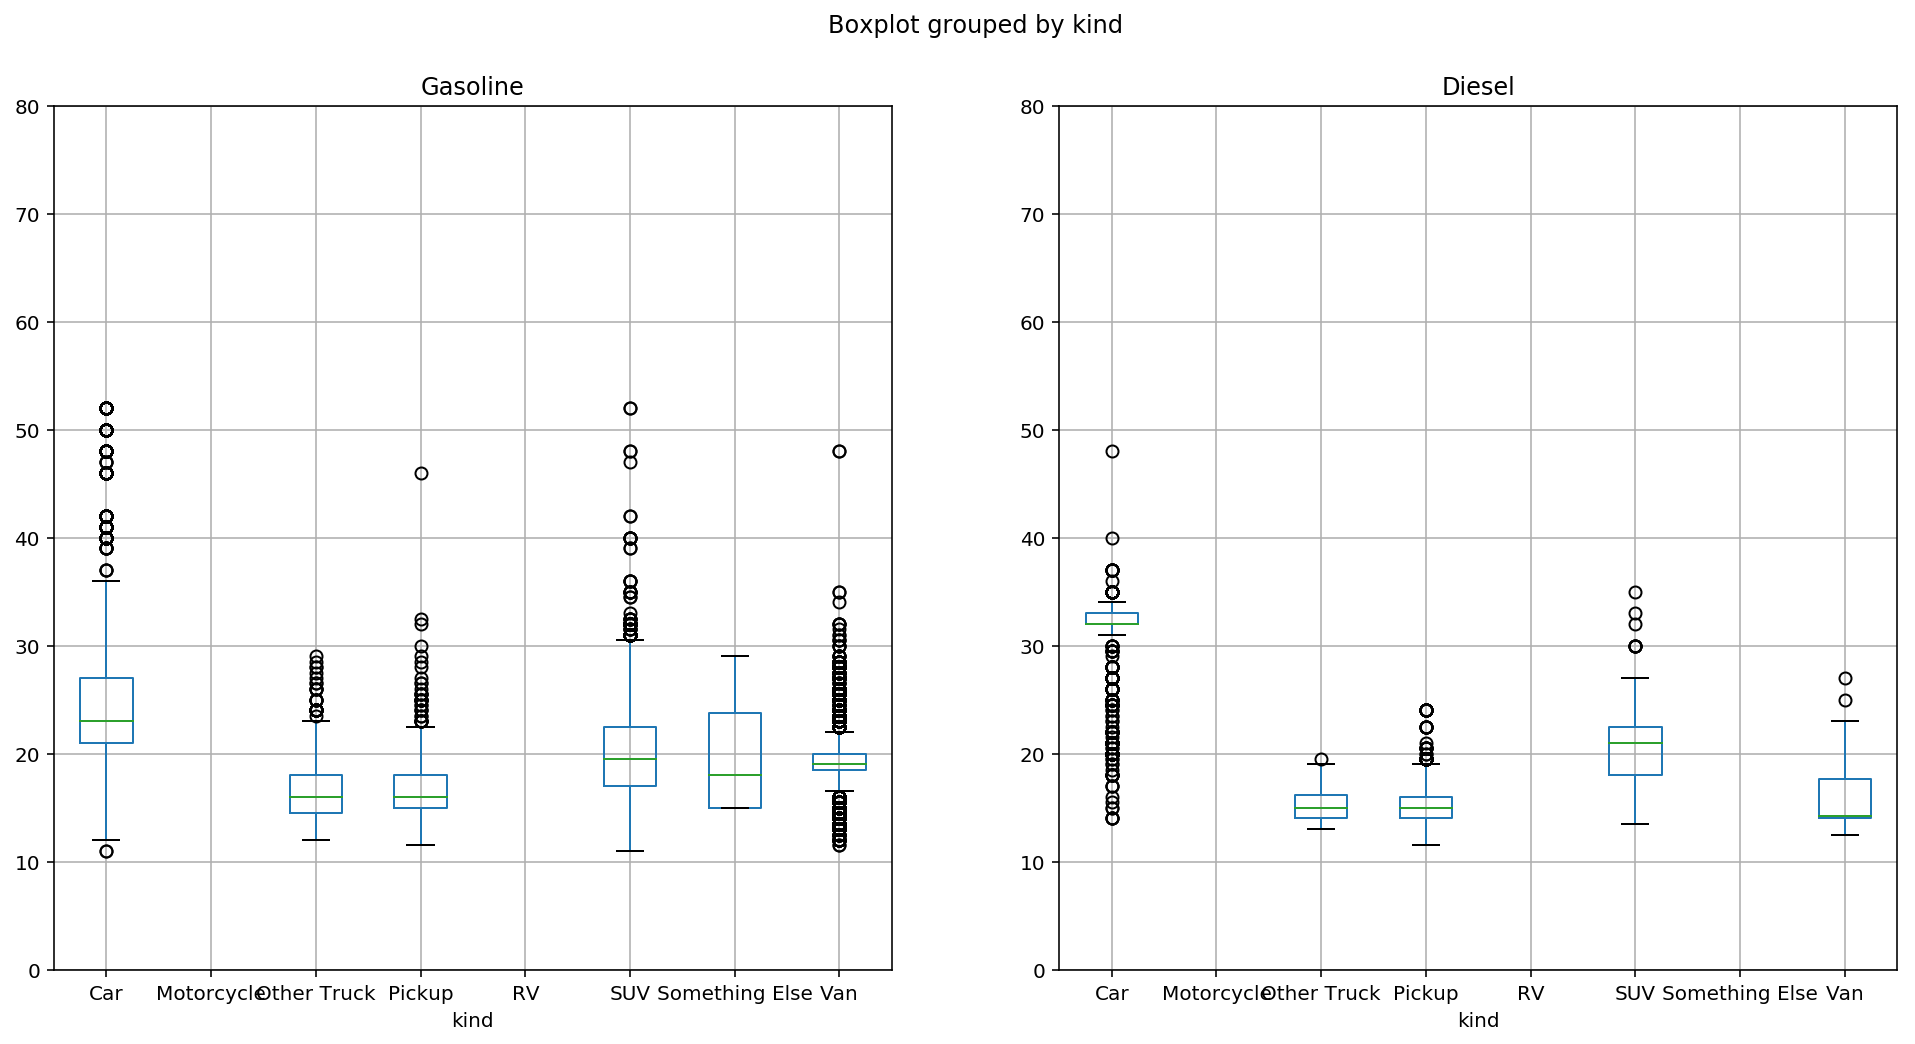

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
for i, fuel in enumerate(['Gasoline', 'Diesel']):
    ax = axes[i]
    vehiclesWithValue[vehiclesWithValue.fuel == fuel].boxplot(column='combined', by='kind', ax=ax)
    ax.set_title(fuel)
    ax.set_ylim(0, 80)

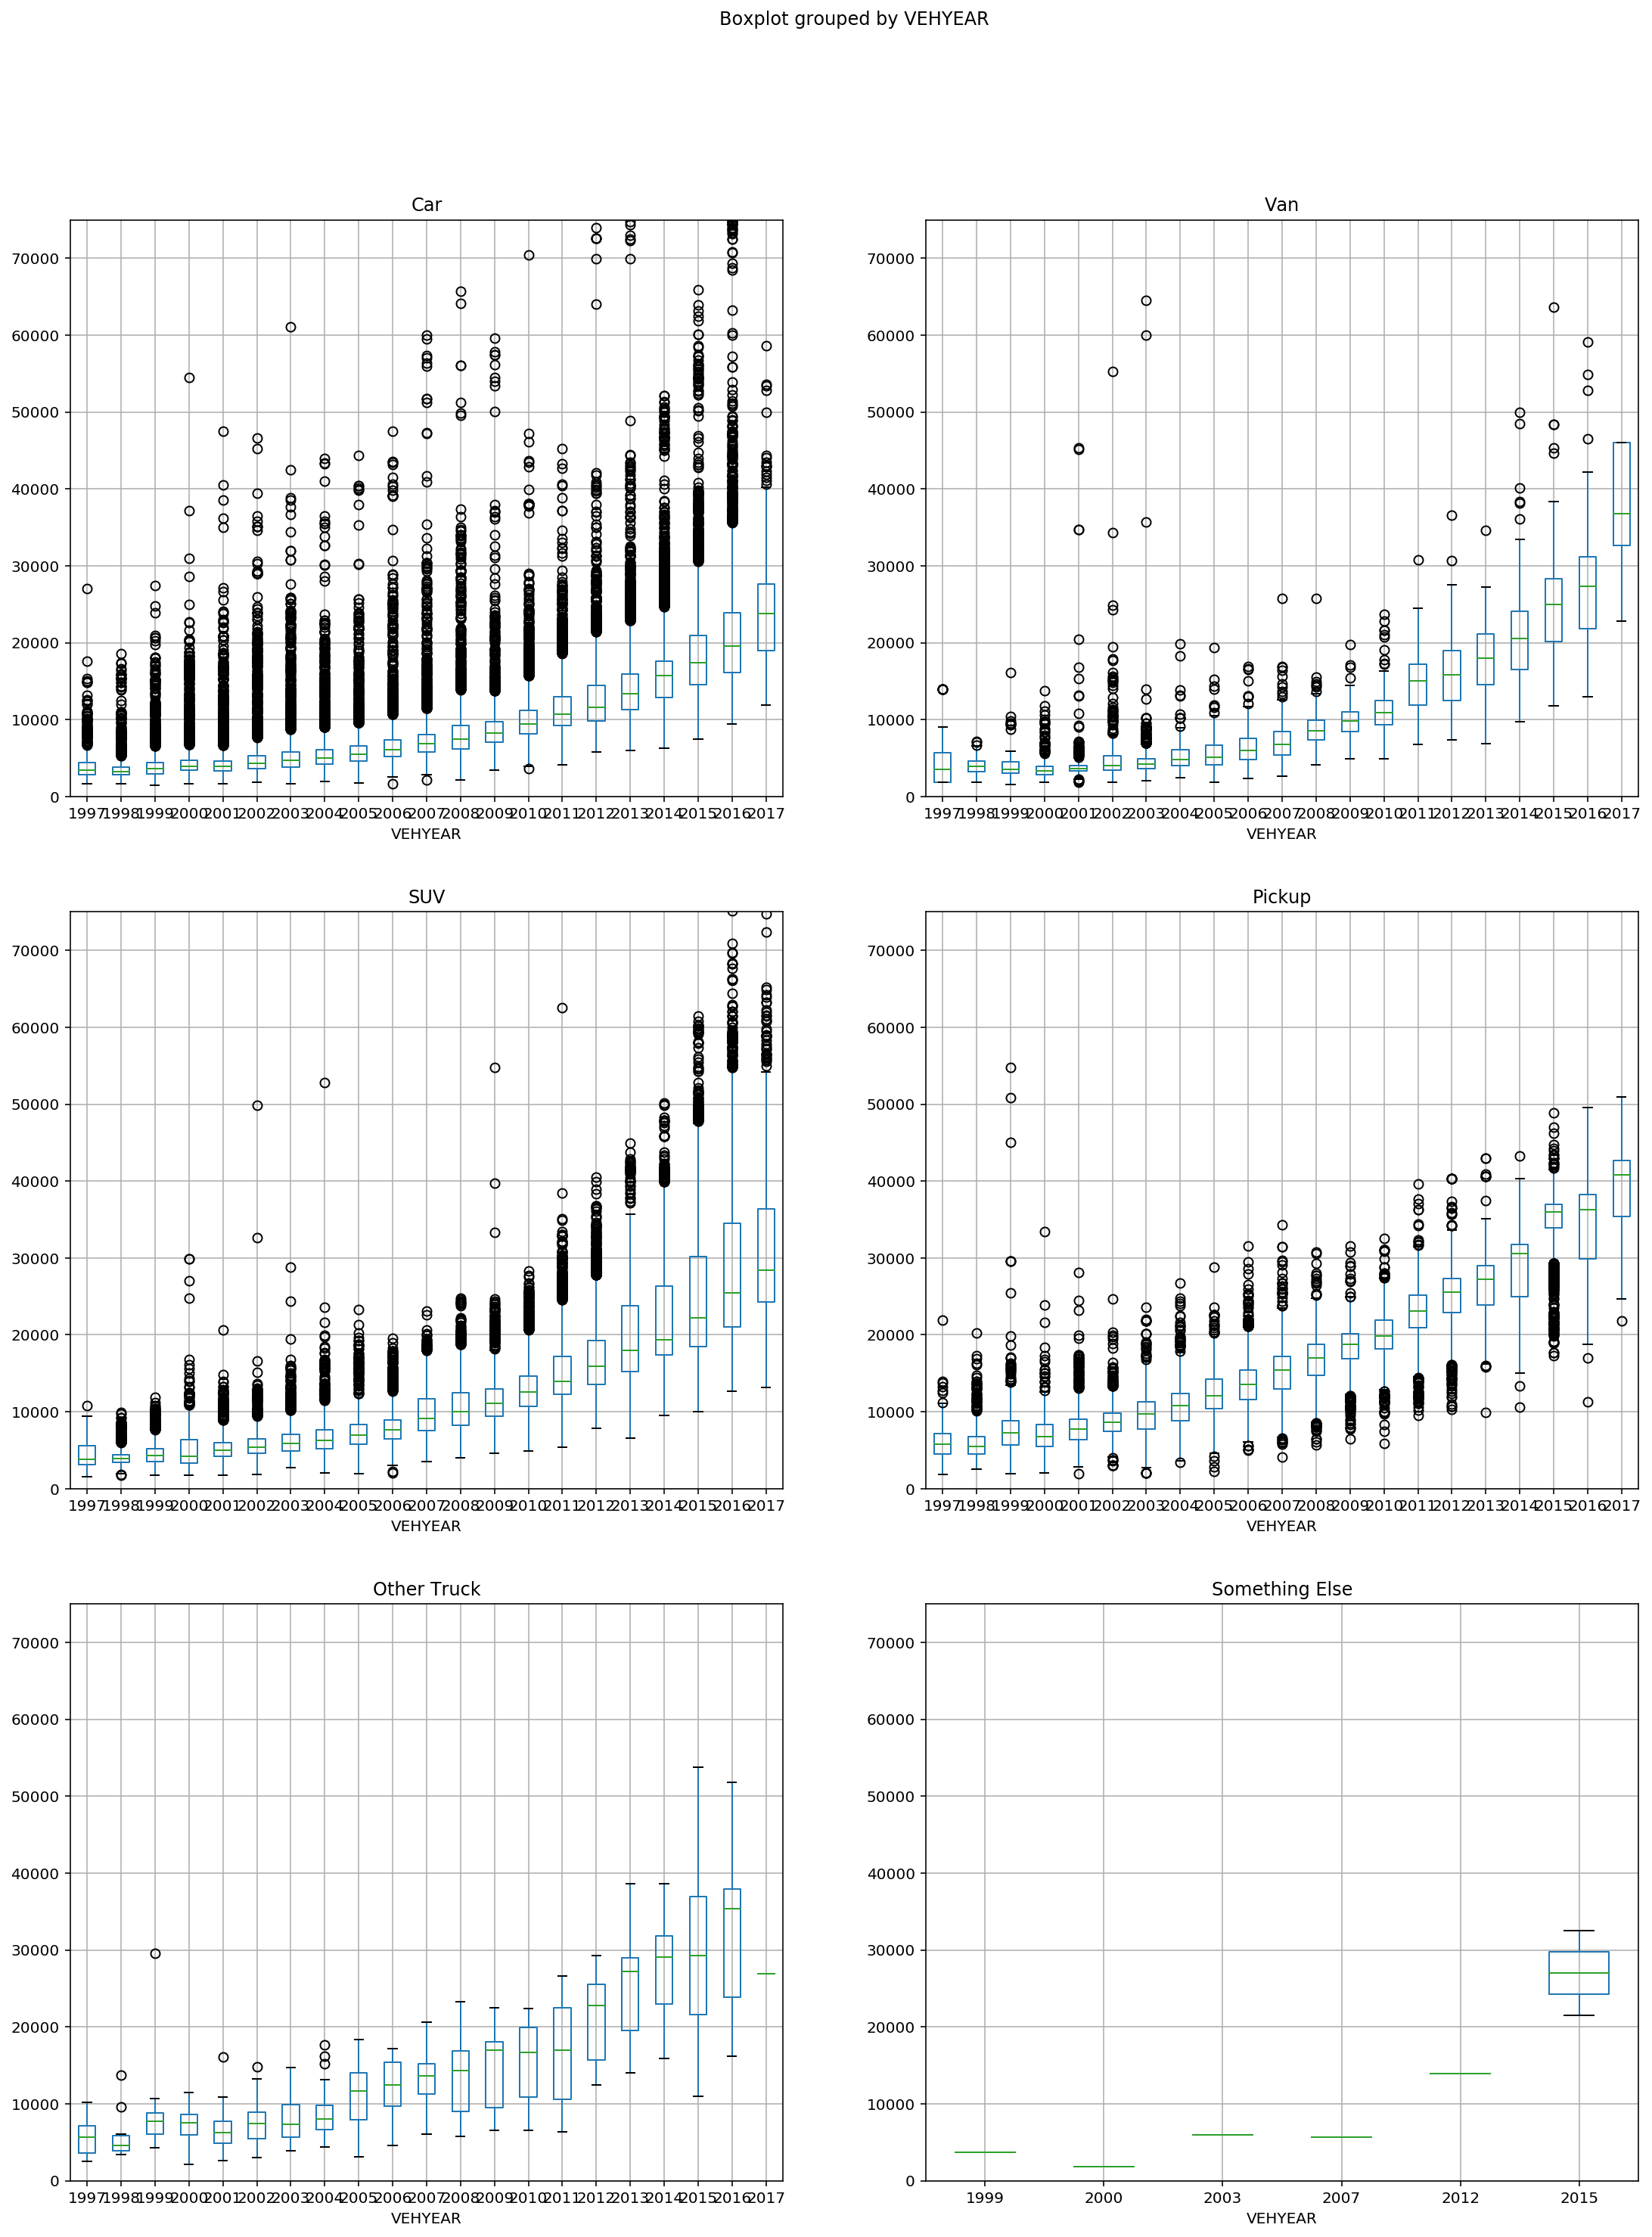

In [21]:
nonna = vehiclesWithValue[['VEHYEAR', 'value', 'kind']].dropna()
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 24))
for i, k in enumerate(nonna.kind.unique()):
    #fig, ax = plt.subplot(3, 2, i + 1)
    vehs = nonna[nonna.kind == k]
    ax = axes[i // 2, i % 2]
    vehs.boxplot(column='value', by='VEHYEAR', ax=ax)
    ax.set_title(k)
    ax.set_ylim(0, 75000)

In [29]:
np.median(sales.Mileage[sales.Year == 2017])

14933.5

In [25]:
sales.columns

Index(['Price', 'Year', 'Mileage', 'City', 'State', 'Vin', 'Make', 'Model',
       'model', 'make', 'year', 'vinStem', 'nhtsaModel', 'cleanModel'],
      dtype='object')

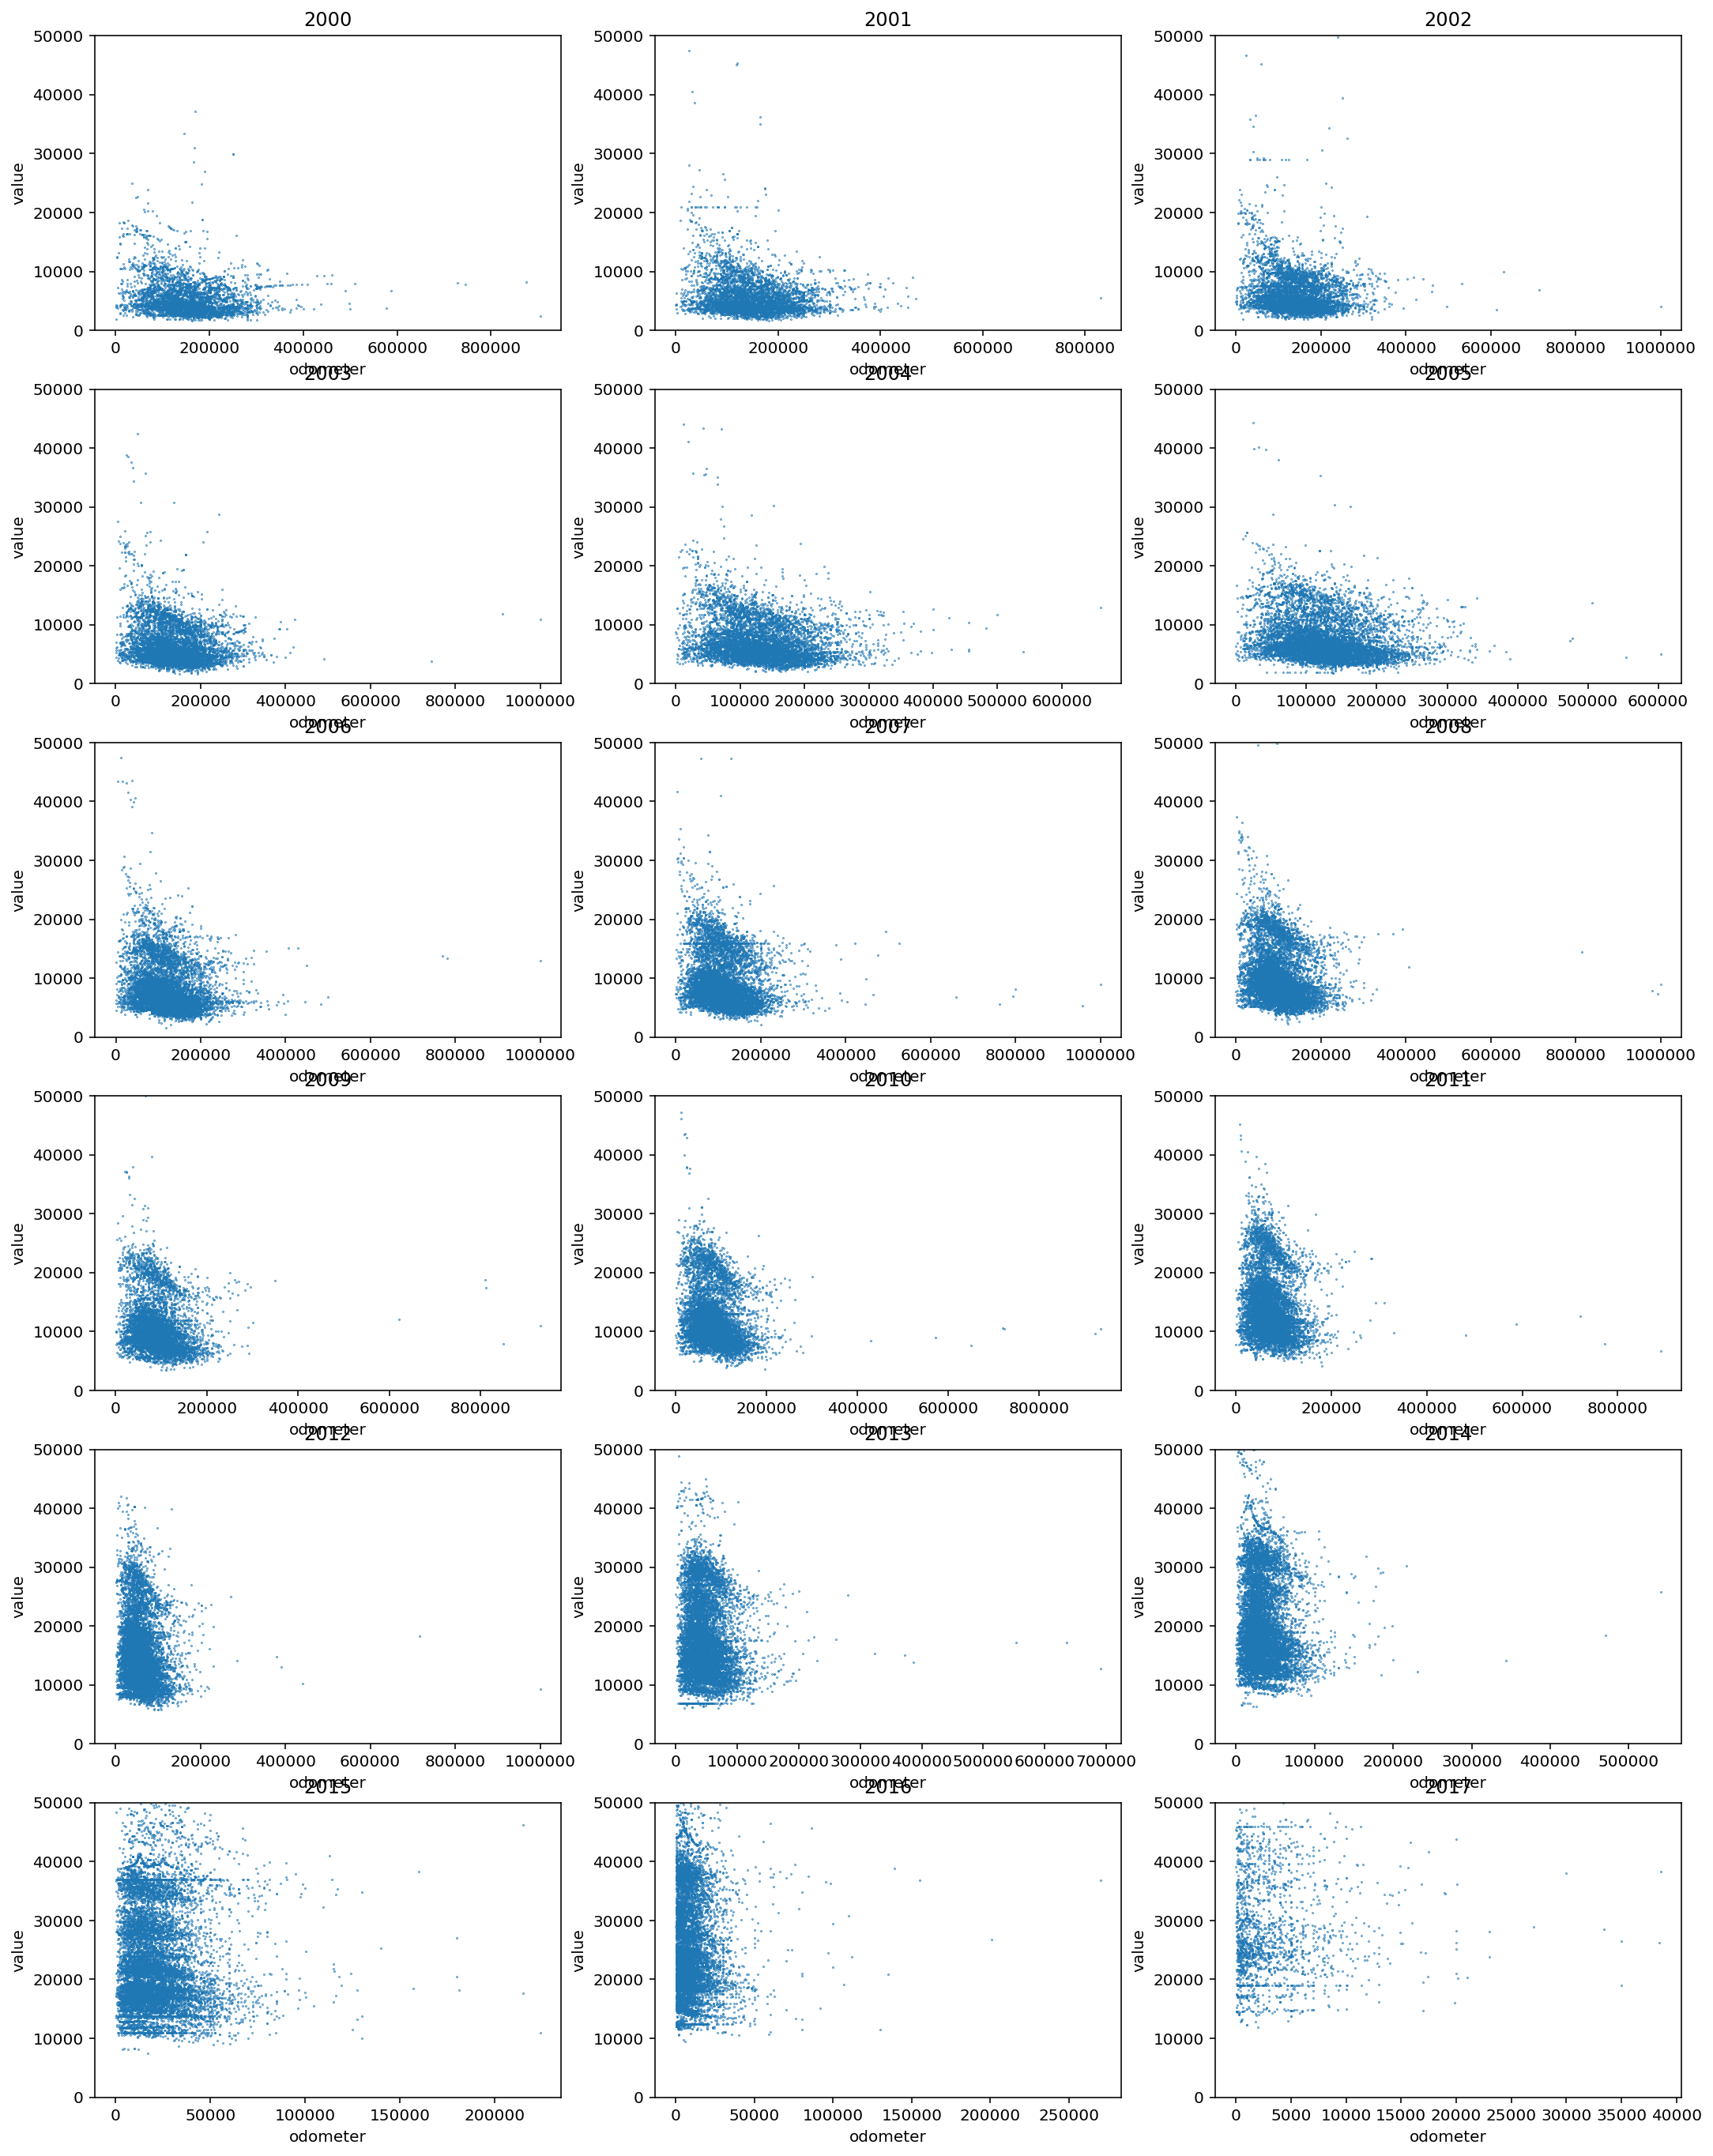

In [22]:
plt.subplots(figsize=(18, 24))
for year in range(2000, 2018):
    vehs = vehiclesWithValue.loc[(vehiclesWithValue.VEHYEAR == year) & (vehiclesWithValue.OD_READ > 0), ['value', 'OD_READ']].dropna()
    plt.subplot(6, 3, year - 1999)
    plt.scatter(vehs.OD_READ, vehs.value, marker='.', s=0.5)
    plt.title(year)
    plt.xlabel('odometer')
    plt.ylabel('value')
    plt.ylim(0, 50000)

In [23]:
vehiclesWithFuelEconomy.makeName[vehiclesWithFuelEconomy.matchAttempted].unique().tolist()

['Toyota',
 'Cadillac',
 'Chevrolet',
 'Infiniti',
 'Ford',
 'Honda',
 'Oldsmobile',
 'Lexus',
 'Nissan',
 'Mazda',
 'Jeep',
 'Subaru',
 'Chrysler',
 'Dodge',
 'Hyundai',
 'Acura',
 'Kia',
 'Buick',
 'Pontiac',
 'Volkswagen',
 'Audi',
 'Mercury',
 'GMC',
 'BMW',
 'Lincoln',
 'Mitsubishi',
 'Saturn',
 'Suzuki',
 'Mercedes-Benz',
 'Volvo',
 'Saab',
 'Porsche',
 'Hummer',
 'Fiat',
 'smart',
 'Scion',
 'Land Rover',
 'Jaguar',
 'Isuzu',
 'Plymouth',
 'American Motors Corporation']